<a href="https://colab.research.google.com/github/shawntharoo/GoogleColabProjects/blob/main/Copy_of_MBA509_Lesson_3_Prescriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MBA509 Lesson 3: Prescriptive Analytics (Causal Models)

### This notebook applies causal machine learrning (EconML and DoubleML) to estimate the effects of certain treatment variables on:

### * PART A: Lending Club loan defaults (the outcome).
### * PART B: Spotify Music Popularity

### Specifically, we want to determine whether specific variables are causal factors of the outcome.



* EconML: https://econml.azurewebsites.net/spec/spec.html
* DoubleML: https://docs.doubleml.org/stable/index.html#doubleml-package
* Double/Debiased ML framework of Chernozhukov et al (https://doi.org/10.1111/ectj.12097)


### We also perform What-If analysis and predict the effects of particular changes in behaviour.



### Double / debiased machine learning Chernozhukov et al. (2018) for

* Partially linear regression models (PLR)

* Partially linear IV regression models (PLIV)

* Interactive regression models (IRM)

* Interactive IV regression models (IIVM)

### The 2021 Nobel Prize in Economics

### https://www.nber.org/news/joshua-angrist-david-card-and-guido-imbens-awarded-2021-nobel-prize


# PART A: The EconML Approach to Lending Club Loans Dataset

### Double Machine Learning is a method for estimating (heterogeneous) treatment effects when all potential confounders/controls (factors that simultaneously had a direct effect on the treatment decision in the collected data and the observed outcome) are observed, but:
* are either too many (high-dimensional) for classical statistical approaches to be applicable, or 
* their effect on the treatment and outcome cannot be satisfactorily modeled by parametric functions (non-parametric). 

###  Both of these latter problems can be addressed via machine learning techniques (see e.g. [Chernozhukov2016]).

### The method reduces the problem to first estimating two predictive tasks:

* predicting the outcome from the controls,

* predicting the treatment from the controls;

### Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment efffect. 

### The approach allows for arbitrary Machine Learning algorithms to be used for the two predictive tasks, while maintaining many favorable statistical properties related to the final model (e.g. small mean squared error, asymptotic normality, construction of confidence intervals).



In [ ]:
%pip install econml

     |████████████████████████████████| 3.3 MB 10.0 MB/s 
     |████████████████████████████████| 77 kB 2.6 MB/s 
     |████████████████████████████████| 356 kB 60.6 MB/s 
     |████████████████████████████████| 123 kB 65.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491667 sha256=3038b1b6fb54102591c7a5d37623756bcffb9c9256c0c0e46d594da4a19490da
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
import econml

In [ ]:
%pip install sklearn

In [ ]:
%pip install lightgbm

In [ ]:
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

# ML
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#import lightgbm
from lightgbm import LGBMClassifier, LGBMRegressor

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import statsmodels.api as sm

###  Lending Club Dataset



### run this  cell if the  dataframe is stored in your Google Drive

In [ ]:
# create a dataframe
df = pd.read_csv('/content/drive/MyDrive/lending_club_pure.csv')

### run this  cell if the data is stored in another data storage e.g. cloud storage

In [ ]:
# create a dataframe
df = pd.read_csv('https://s3.ap-northeast-1.wasabisys.com/pubdatasets/lending_club_pure.csv')

In [ ]:
df

,Unnamed: 0,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w,TARGET
0,0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1,0
1,1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1,0
2,2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1,0
3,3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1,0
4,4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1,0
415463,415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0,0
415464,415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0,0
415465,415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0,0


In [ ]:
# remove unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df

,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w,TARGET
0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1,0
1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1,0
2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1,0
3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1,0
4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1,0
415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0,0
415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0,0
415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0,0


In [ ]:
df.shape

# Data Features

In [ ]:
# get the names of every column
feature_names = df.columns
feature_names

Index(['last_pymnt_d', 'out_prncp', 'issue_d', 'last_credit_pull_d',
       'int_rate', 'total_pymnt', 'revol_bal', 'earliest_cr_line',
       'last_pymnt_amnt', 'total_rec_int', 'total_acc', 'dti',
       'inq_last_6mths', 'revol_util', 'total_rec_late_fee', 'term',
       'verification_status_Verified', 'initial_list_status_w', 'TARGET'],
      dtype='object')

In [ ]:
# filter for only  numerical data  types
numerical_data = df.select_dtypes(exclude=["category", "object"])

In [ ]:
numerical_data

,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w,TARGET
0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1,0
1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1,0
2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1,0
3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1,0
4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1,0
415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0,0
415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0,0
415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0,0


## Separate the features  (variables that influences the outcomes) and the TARGET variable (True/False, 0/1) if customers has defaulted on their loan(s).


In [ ]:
data = numerical_data.drop(['TARGET'], axis=1)

In [ ]:
data

,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w
0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1
1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1
2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1
3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1
4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1
415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0
415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0
415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0


In [ ]:
data.columns

Index(['last_pymnt_d', 'out_prncp', 'issue_d', 'last_credit_pull_d',
       'int_rate', 'total_pymnt', 'revol_bal', 'earliest_cr_line',
       'last_pymnt_amnt', 'total_rec_int', 'total_acc', 'dti',
       'inq_last_6mths', 'revol_util', 'total_rec_late_fee', 'term',
       'verification_status_Verified', 'initial_list_status_w'],
      dtype='object')

In [ ]:
feature_names = ['last_pymnt_d', 'out_prncp', 'issue_d', 'last_credit_pull_d',
       'int_rate', 'total_pymnt', 'revol_bal', 'earliest_cr_line',
       'last_pymnt_amnt', 'total_rec_int', 'total_acc', 'dti',
       'inq_last_6mths', 'revol_util', 'total_rec_late_fee', 'term',
       'verification_status_Verified', 'initial_list_status_w']

In [ ]:
# how many features
len(feature_names)

# Set loan default  as the outcome (also called the target variable)

In [ ]:
target = df.TARGET

In [ ]:
target.shape

# Scale Data

* required for ML
* use simple standard scaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

* Standardize features by removing the mean and scaling to unit variance.

* The standard score of a sample x is calculated as:

z = (x - u) / s

* where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

* Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

* Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(data)
print(scaled)

[[ 0.74457015  0.0458595  -1.40372072 ... -0.69686821  1.33451896
   0.95804324]
 [ 0.74457015 -0.5986748  -1.40372072 ... -0.69686821 -0.74933368
   0.95804324]
 [-0.71161328 -1.07674313 -1.40372072 ... -0.69686821 -0.74933368
   0.95804324]
 ...
 [ 0.74457015 -0.12807786  0.90324443 ... -0.69686821  1.33451896
  -1.04379422]
 [ 0.74457015 -0.14713058  0.90324443 ... -0.69686821  1.33451896
  -1.04379422]
 [ 0.74457015  0.8206031   0.90324443 ... -0.69686821  1.33451896
  -1.04379422]]


In [ ]:
scaled.shape

### Data Sampling - given time constraints, take a small sample to run notebook

### Notes: without sampling, the processes of calculating causal effects may take hours depending on the size of the data.
### https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

##  Add a constant column (=1) to the scaled data

In [ ]:
X = sm.add_constant(scaled)
X

array([[ 1.        ,  0.74457015,  0.0458595 , ..., -0.69686821,
         1.33451896,  0.95804324],
       [ 1.        ,  0.74457015, -0.5986748 , ..., -0.69686821,
        -0.74933368,  0.95804324],
       [ 1.        , -0.71161328, -1.07674313, ..., -0.69686821,
        -0.74933368,  0.95804324],
       ...,
       [ 1.        ,  0.74457015, -0.12807786, ..., -0.69686821,
         1.33451896, -1.04379422],
       [ 1.        ,  0.74457015, -0.14713058, ..., -0.69686821,
         1.33451896, -1.04379422],
       [ 1.        ,  0.74457015,  0.8206031 , ..., -0.69686821,
         1.33451896, -1.04379422]])

In [ ]:
X.shape

# Build a simple Ordinary Least Squares to test

### Create the dataframe

In [ ]:
# Train a linear regression using statsmodels
X_df = pd.DataFrame(X, columns=["Intercept"] + feature_names)

In [ ]:
X_df

,Intercept,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w
0,1.0,0.744570,0.045859,-1.403721,-1.734982,-0.453947,1.596417,0.549276,-0.781387,-0.282507,1.023154,-0.110164,0.241887,-0.701592,0.228174,-0.085487,-0.696868,1.334519,0.958043
1,1.0,0.744570,-0.598675,-1.403721,0.366134,-1.446483,0.080418,-0.280568,0.066415,-0.382304,-0.380463,-0.533643,-0.260256,0.321440,-1.454754,-0.085487,-0.696868,-0.749334,0.958043
2,1.0,-0.711613,-1.076743,-1.403721,0.366134,0.122950,0.632287,-0.549145,0.490317,-0.430422,-0.267488,0.313316,-0.095721,-0.701592,0.551161,-0.085487,-0.696868,-0.749334,0.958043
3,1.0,0.744570,-0.466161,-1.403721,0.366134,-0.928638,0.396660,-0.341985,0.490317,-0.361486,-0.032528,0.059228,-0.120202,-0.701592,0.780651,-0.085487,-0.696868,-0.749334,0.958043
4,1.0,0.744570,-0.574155,-1.403721,0.366134,-0.226823,0.168580,-0.364118,0.384341,-0.376500,0.043905,-0.787731,-0.318327,0.321440,0.474664,-0.085487,-0.696868,-0.749334,-1.043794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,1.0,0.744570,0.182712,0.903244,-1.734982,0.454552,-0.544084,-0.722398,0.066415,-0.393052,-0.059088,-1.211210,-1.003223,-0.701592,-2.236721,-0.085487,1.434992,1.334519,0.958043
415463,1.0,0.744570,-0.490489,0.903244,0.366134,-0.794635,-0.648742,-0.521248,0.066415,-0.407056,-0.607233,0.059228,0.399021,-0.701592,-0.507044,-0.085487,-0.696868,1.334519,-1.043794
415464,1.0,0.744570,-0.128078,0.903244,0.366134,-0.226823,-0.417642,0.000242,0.172391,-0.376500,-0.324783,2.769497,0.288572,-0.701592,0.589409,-0.085487,-0.696868,1.334519,-1.043794
415465,1.0,0.744570,-0.147131,0.903244,0.366134,0.590827,-0.405782,-0.100315,0.596292,-0.375324,-0.165926,-0.872427,0.481572,-0.701592,0.389668,-0.085487,-0.696868,1.334519,-1.043794


### Create the model - Ordinary Least Squares

### https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

In [ ]:
model = sm.OLS(target, X_df)

### Train model

In [ ]:
results = model.fit()

### Examine results of training

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     64.70
Date:                Thu, 07 Apr 2022   Prob (F-statistic):          9.51e-236
Time:                        23:23:51   Log-Likelihood:             7.9533e+05
No. Observations:              415467   AIC:                        -1.591e+06
Df Residuals:                  415448   BIC:                        -1.590e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0013   5.54e-05     23.090      0.000       0.001       0.001
last_pymnt_d                    -0.0020   7.69e-05    -25.390      0.000      -0.002      -0.002
out_prncp                        0.0008   8.67e-05      9.276      0.000       0.001       0.001
issue_d                         -0.0001   9.34e-05     -1.417      0.156      -0.000    5.07e-05
last_credit_pull_d               0.0009   7.17e-05     12.147      0.000       0.001       0.001
int_rate                         0.0006   7.97e-05      7.323      0.000       0.000       0.001
total_pymnt                     -0.0004      0.000     -2.685      0.007      -0.001      -0.000
revol_bal                       -0.0001      6e-05     -1.737      0.082      -0.000    1.34e-05
earliest_cr_line              8.499e-06   5.55e-05      0.153      0.878      -0.000       0.000
last_pymnt_amnt                 -0.0005      0.000     -4.436      0.000      -0.001      -0.000
total_rec_int                    0.0004      0.000      2.806      0.005       0.000       0.001
total_acc                    -1.522e-05   5.84e-05     -0.260      0.795      -0.000    9.93e-05
dti                           8.709e-05   5.62e-05      1.549      0.121   -2.31e-05       0.000
inq_last_6mths               -4.645e-05   5.94e-05     -0.782      0.434      -0.000       7e-05
revol_util                      -0.0001   6.12e-05     -2.030      0.042      -0.000   -4.27e-06
total_rec_late_fee               0.0005   5.57e-05      9.569      0.000       0.000       0.001
term                            -0.0003    7.5e-05     -3.687      0.000      -0.000      -0.000
verification_status_Verified  4.152e-05   5.84e-05      0.711      0.477   -7.29e-05       0.000
initial_list_status_w         -3.62e-05   5.93e-05     -0.611      0.541      -0.000       8e-05
==============================================================================
Omnibus:                  1037210.756   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      10399592107.824
Skew:                          27.801   Prob(JB):                         0.00
Kurtosis:                     776.081   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Split data into training and testing (sub)-datasets

* the split is random
* training: for training ML
* testing: ONLY to assess the ML performance

###  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
scaled.shape

#  The scaled data has 415,467 rows of data and 18 columns
#  We can use a smaller sample size, say  the first 10,000 rows to for demo (to speed up the demo)

In [ ]:
small_scaled = scaled[:10000]

In [ ]:
small_scaled.shape

In [ ]:
small_target = target[:10000]

# This is the datasplit for the small_scaled dataset

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split

# test size 20%
x_train, x_test, y_train, y_test = train_test_split(
    small_scaled, small_target, test_size=0.2, random_state=0
)

In [ ]:
x_train.shape

In [ ]:
x_test.shape

# This is the datasplit for the FULL dataset

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split

# test size 20%
x_train, x_test, y_train, y_test = train_test_split(
    scaled, target, test_size=0.2, random_state=0
)

# Identify Categorical Data

In [ ]:
df

,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w,TARGET
0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1,0
1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1,0
2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1,0
3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1,0
4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1,0
415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0,0
415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0,0
415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0,0


In [ ]:
categorical = ["verification_status_Verified","initial_list_status_w"]
# Store the numerical columns in a list numerical
numerical = list(set(feature_names).difference(set(categorical)))

In [ ]:
numerical

['inq_last_6mths',
 'total_rec_late_fee',
 'revol_util',
 'total_pymnt',
 'revol_bal',
 'term',
 'last_credit_pull_d',
 'total_acc',
 'last_pymnt_d',
 'earliest_cr_line',
 'total_rec_int',
 'out_prncp',
 'last_pymnt_amnt',
 'dti',
 'issue_d',
 'int_rate']

# Using LightGBM
* Classifier:  https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

* Regressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html


### LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel, distributed, and GPU learning.

* Capable of handling large-scale data.



### Paramater Search: GridSearchCV

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

*  Exhaustive search over specified parameter values for an estimator.

* Important members are fit, predict.

* GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

* The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.



In [ ]:
# train a lightGBM regression model
lgbm_model = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(lgbm_model, param_grid, n_jobs=-1)

In [ ]:
# search for the best lgbm estimator
search.fit(x_train, y_train)
print("Best estimator: ", search.best_params_)

Best estimator:  {'learning_rate': 0.01, 'max_depth': 10}


In [ ]:
# apply to test data
print("Test set score: ", search.best_estimator_.score(x_test, y_test))

Test set score:  -0.001846724544256384


# Correlation Interpretation:  SHAP Values

## Feature Importance - Shap Value

### We explain this ML model by understanding the top important features to predict loan default, internally using shap value.

### https://shap.readthedocs.io/en/latest/index.html

### SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. 


In [ ]:
fitted_model = search.best_estimator_

In [ ]:
import shap

# use interventional approach
background = shap.maskers.Independent(x_train, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=feature_names
)
shap_values = explainer(x_test, check_additivity=False)

100%|===================| 1990/2000 [01:02<00:00]       

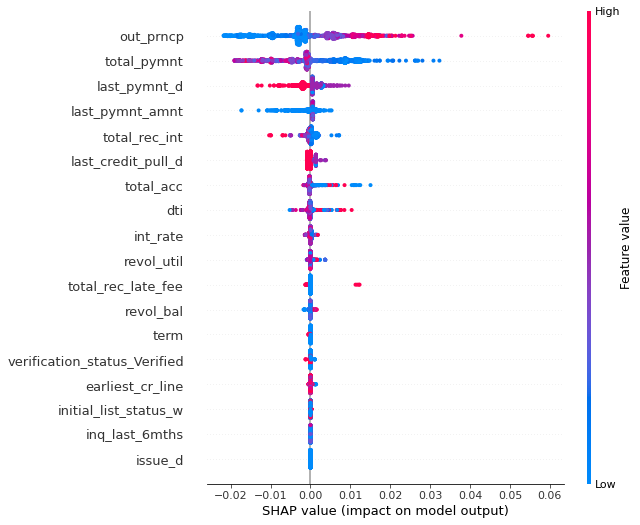

In [ ]:
# plot the feature importance
shap.summary_plot(shap_values, x_test)

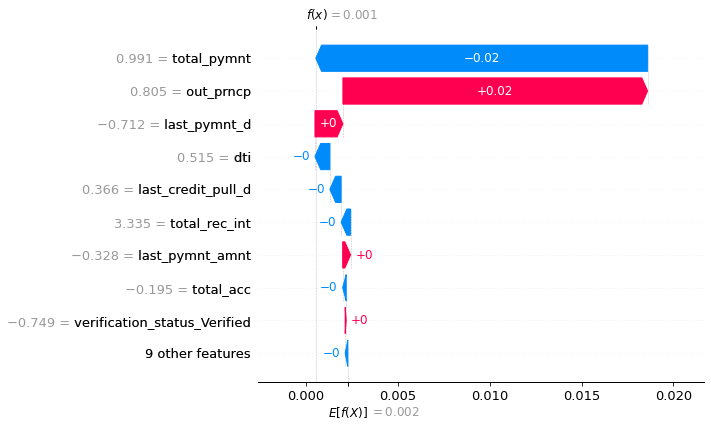

In [ ]:
shap.plots.waterfall(shap_values[0])

# Partial Dependence Plots - Statistical relationship between loan default and various features

### Notes: change 'smalled_scaled' to 'scaled' in *pd.DataFrame(small_scaled, columns=feature_names)* to use the full dataset

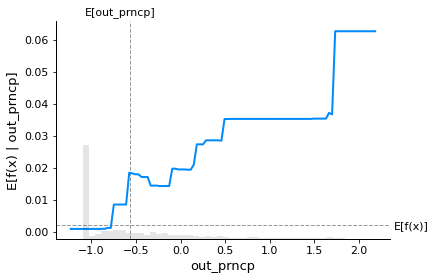

In [ ]:
shap.plots.partial_dependence(
    "out_prncp",
    fitted_model.predict,
    pd.DataFrame(small_scaled, columns=feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### Notes: change 'smalled_scaled' to 'scaled' in *pd.DataFrame(small_scaled, columns=feature_names)* to use the full dataset

Attempting to set identical left == right == -1.4037207185556104 results in singular transformations; automatically expanding.


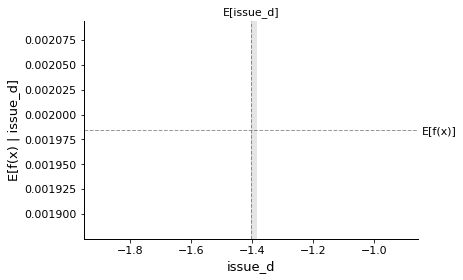

In [ ]:
shap.plots.partial_dependence(
    "issue_d",
    fitted_model.predict,
    pd.DataFrame(small_scaled, columns=feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### Notes: change 'smalled_scaled' to 'scaled' in *pd.DataFrame(small_scaled, columns=feature_names)* to use the full dataset

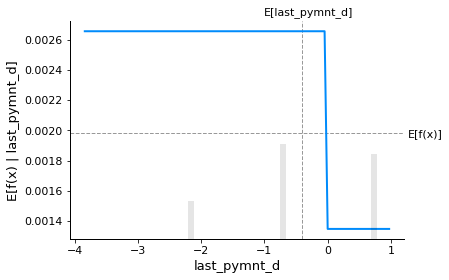

In [ ]:
shap.plots.partial_dependence(
    "last_pymnt_d",
    fitted_model.predict,
    pd.DataFrame(small_scaled, columns=feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### Notes: change 'smalled_scaled' to 'scaled' in *pd.DataFrame(small_scaled, columns=feature_names)* to use the full dataset

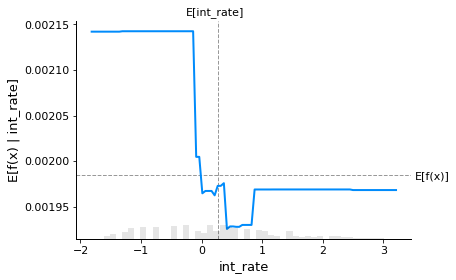

In [ ]:
shap.plots.partial_dependence(
    "int_rate",
    fitted_model.predict,
    pd.DataFrame(small_scaled, columns=feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### Overall, all the insights above are coming from corelation perspective, telling us the positive or negative correlation between each predictor and the target. 

### In order to correctly find the *casusal relationship*, we have to train a different model, controlling on all the possible hidden variables (confounders) and learn the direct causal effect for a given feature. 

# Causal Interpretation

### In the following section, we will explore the causal relationship in different ways.

### Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?

###  https://econml.azurewebsites.net/_autosummary/econml.solutions.causal_analysis.CausalAnalysis.html

In [ ]:
classification = False
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance["features"]

## Now apply Causal Analysis on the top features (from features_importances)

### For each feature, we learn the Average Treatment Effect (ATE). 

In [ ]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=classification,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
)
ca.fit(pd.DataFrame(x_train, columns=feature_names), y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [ ]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
int_rate,1.733651e-02,4.935422e-03,3.512670,0.000444,7.663258e-03,2.700976e-02
last_pymnt_d,-3.272317e-03,9.688884e-04,-3.377393,0.000732,-5.171303e-03,-1.373331e-03
total_pymnt,-4.209501e-02,1.379178e-02,-3.052180,0.002272,-6.912641e-02,-1.506361e-02
total_rec_int,-3.952972e-02,1.510251e-02,-2.617426,0.008860,-6.913010e-02,-9.929335e-03
out_prncp,3.597051e-02,2.087528e-02,1.723116,0.084868,-4.944275e-03,7.688530e-02
total_rec_late_fee,1.758742e-03,1.292768e-03,1.360447,0.173689,-7.750366e-04,4.292520e-03
last_pymnt_amnt,1.601046e-01,1.354531e-01,1.181993,0.237208,-1.053786e-01,4.255877e-01
earliest_cr_line,-2.922965e-04,2.740734e-04,-1.066490,0.286202,-8.294705e-04,2.448775e-04
total_acc,-6.405061e-04,6.054601e-04,-1.057883,0.290109,-1.827186e-03,5.461739e-04


# Visualisation of causal effects (Average Treatment Effect)

In [ ]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

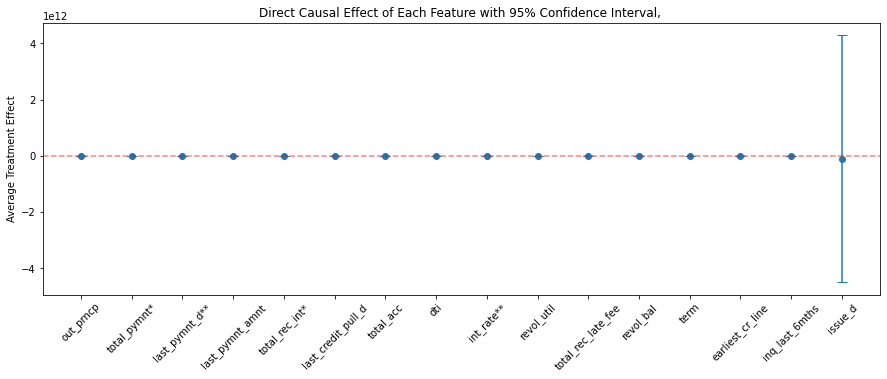

In [ ]:
errorbar(global_summ)

## The error bar in the chart (above) is ordered by feature importance, and the summary table above is ordered by causal significance (p-value). 

* ATE: generally understood as a causal parameter (i.e., an estimate or property of a population) needed to be known but without reference to the study design or estimation procedure
* CATE: Conditional Average Treatment Effects


### The p-value is widely used in statistical hypothesis testing, specifically in null hypothesis significance testing. 

### Before conducting a study:
* first select a model (the null hypothesis), and 
* the alpha level α (most commonly .05). 

### After analyzing the data, if the p-value is less than α, that is taken to mean the observed data is sufficiently inconsistent with the null hypothesis for the null hypothesis to be rejected. 

### However, that does not prove that the null hypothesis is false. The p-value does not, in itself, establish probabilities of hypotheses. Rather, it is a tool for deciding whether to reject the null hypothesis.

#  Segmentation - How different customers respond differently to changes in specific feature of interest

### In the following section, we are going to use the loan issue date as an example to learn how different types of customers respond differently.

### Heterogeneity Tree - customer responses to the "issue date"  (issue_d)

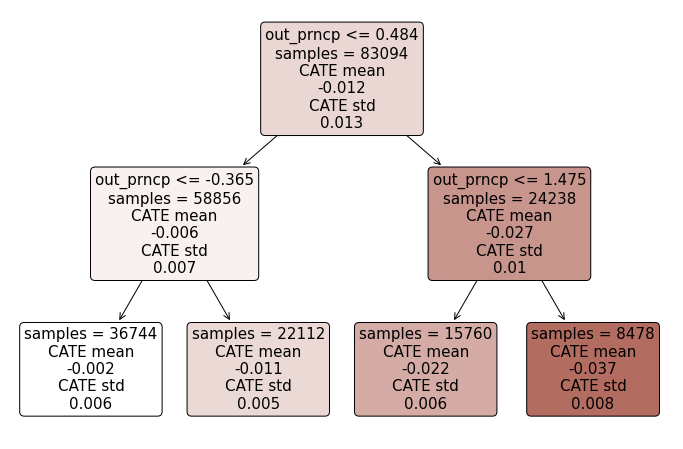

In [ ]:
# Plot an effect hetergoeneity tree using matplotlib.
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    pd.DataFrame(x_test, columns=feature_names),
    "issue_d",
    max_depth=2,
    min_impurity_decrease=1e-6,
)

### Heterogeneity Tree - customer responses to the "the outstanding principle"  (out_prncp)

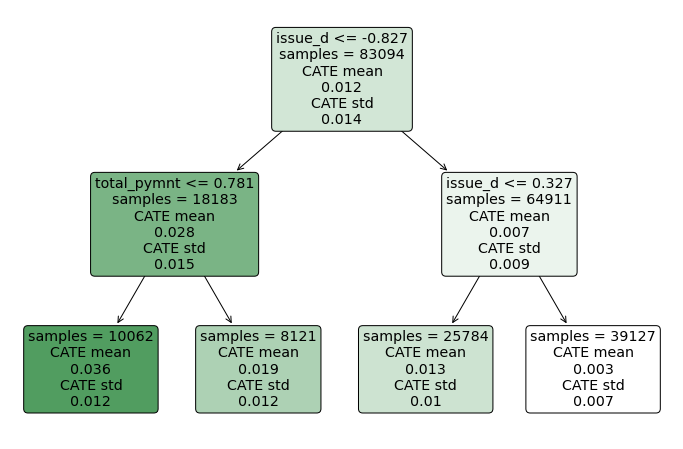

In [ ]:
# Plot an effect hetergoeneity tree using matplotlib.
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    pd.DataFrame(x_test, columns=feature_names),
    "out_prncp",
    max_depth=2,
    min_impurity_decrease=1e-6,
)

# Policy Analysis -- What is the best policy considering certain features?

### Policy Tree - what happens when the issue date changes? 

### That is, suppose that the issue date increases (earlier issue dates), what would be the response?

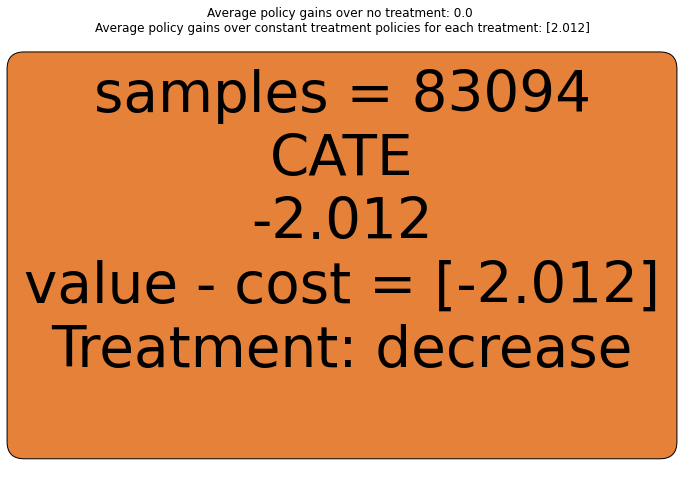

In [ ]:
# suppose that the issue date is increased by 1 unit
plt.figure(figsize=(12, 8))
ca.plot_policy_tree(
    pd.DataFrame(x_test, columns=feature_names),
    "issue_d",
    treatment_costs=2,
    max_depth=3,
)

# Individualised Policy

###  Top n customer defaults ordered by policy gains (increase in the issue date i.e. when the loan was provided - further back in history)

###  Note that here the effect of treatment is the treatment effect of:
* increasing or decreasing 10% of average treatment level minus the cost, and 
* decrease or increase indicates which direction we will get positive policy gain.

In [ ]:
ca.individualized_policy(
    pd.DataFrame(x_test, columns=feature_names),
    "issue_d",
    n_rows=5,
    treatment_costs=2,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,last_pymnt_d,out_prncp,Current treatment,last_credit_pull_d,int_rate,total_pymnt,...,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w
44765,decrease,2.005380,2.004434,2.006326,-0.711613,2.680819,0.903244,0.366134,1.408476,-0.694766,...,-0.205128,-0.414871,-0.025468,-0.305802,0.321440,-2.245220,-0.085487,-0.696868,1.334519,0.958043
15128,decrease,2.005274,2.004290,2.006259,-0.711613,2.812497,0.903244,0.366134,2.952925,-0.884310,...,-0.251188,-0.584630,-0.618339,-0.686110,1.344471,-2.304718,-0.085487,1.434992,1.334519,-1.043794
55779,decrease,2.005243,2.004309,2.006178,-0.711613,2.761819,0.903244,0.366134,1.106400,-0.854160,...,-0.209655,-0.677366,1.499058,-0.183967,-0.701592,-2.266469,-0.085487,-0.696868,-0.749334,0.958043
54750,decrease,2.005229,2.004326,2.006133,-0.711613,2.755549,0.903244,0.366134,0.043456,-0.860211,...,-0.225203,-0.724964,-1.041818,-0.317758,1.344471,-0.787532,-0.085487,-0.696868,-0.749334,0.958043
41452,decrease,2.005195,2.004155,2.006235,-0.711613,2.804477,0.903244,0.366134,1.194979,-0.783235,...,-0.276635,-0.263779,-1.634690,-0.213571,0.321440,1.634865,11.365956,1.434992,-0.749334,0.958043


In [ ]:
ca.individualized_policy(
    pd.DataFrame(x_test, columns=feature_names),
    "out_prncp",
    n_rows=5,
    treatment_costs=2,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,last_pymnt_d,Current treatment,issue_d,last_credit_pull_d,int_rate,total_pymnt,...,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w
41568,decrease,2.003909,2.003200,2.004619,0.744570,-1.076743,0.903244,0.366134,0.795239,3.929512,...,5.520402,1.531779,1.922538,0.468478,-0.701592,0.614908,-0.085487,1.434992,1.334519,-1.043794
42797,decrease,2.003732,2.003101,2.004362,0.744570,-1.076743,0.903244,0.366134,-0.681072,3.635948,...,5.445108,0.447528,0.736795,-0.445855,-0.701592,-0.872529,-0.085487,1.434992,1.334519,0.958043
52750,decrease,2.003418,2.002574,2.004262,-0.711613,-1.076743,0.903244,0.366134,0.595369,3.365470,...,6.324572,-0.551454,4.294023,-0.247161,0.321440,-0.740784,-0.085487,1.434992,1.334519,0.958043
13438,decrease,2.003372,2.002744,2.003999,0.744570,-1.076743,0.903244,0.366134,0.377329,3.773246,...,5.657889,0.954628,-1.041818,-0.214710,-0.701592,1.350127,-0.085487,1.434992,1.334519,0.958043
11916,decrease,2.003368,2.002683,2.004052,-0.711613,-1.076743,0.903244,0.366134,-0.158685,3.627256,...,5.247639,0.415427,1.668450,-0.584201,-0.701592,-2.104976,-0.085487,1.434992,-0.749334,0.958043


# Counterfactuals: "What if..." Analysis

### The causal analysis tool could also answer what if types of questions. 
### For a given treatment, we'd also like to know the counterfactuals (expressing what has not happened but could, would, or might under differing conditions) if we intervene it in a different way. 

### In the example below, we will learn how the overall loan default changes with one unit increase in issue date (loans that have  been issue much later)

In [ ]:
feature_names

['last_pymnt_d',
 'out_prncp',
 'issue_d',
 'last_credit_pull_d',
 'int_rate',
 'total_pymnt',
 'revol_bal',
 'earliest_cr_line',
 'last_pymnt_amnt',
 'total_rec_int',
 'total_acc',
 'dti',
 'inq_last_6mths',
 'revol_util',
 'total_rec_late_fee',
 'term',
 'verification_status_Verified',
 'initial_list_status_w']

In [ ]:
data

,last_pymnt_d,out_prncp,issue_d,last_credit_pull_d,int_rate,total_pymnt,revol_bal,earliest_cr_line,last_pymnt_amnt,total_rec_int,total_acc,dti,inq_last_6mths,revol_util,total_rec_late_fee,term,verification_status_Verified,initial_list_status_w
0,2016,10018.90,2013,2015,10.99,21251.04,36638,1986.0,885.46,4219.94,27.0,22.87,0.0,61.2,0.0,36,1,1
1,2016,4266.62,2013,2016,6.62,8842.80,13168,1994.0,368.45,1109.42,22.0,14.05,1.0,21.6,0.0,36,0,1
2,2015,0.00,2013,2016,13.53,13359.77,5572,1998.0,119.17,1359.78,32.0,16.94,0.0,68.8,0.0,36,0,1
3,2016,5449.27,2013,2016,8.90,11431.20,11431,1998.0,476.30,1880.47,29.0,16.51,0.0,74.2,0.0,36,0,1
4,2016,4485.45,2013,2016,11.99,9564.40,10805,1997.0,398.52,2049.85,19.0,13.03,1.0,67.0,0.0,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415462,2016,11240.27,2015,2015,14.99,3731.34,672,1994.0,312.77,1821.61,14.0,1.00,0.0,3.2,0.0,60,1,1
415463,2016,5232.15,2015,2016,9.49,2874.73,6361,1994.0,240.22,606.88,29.0,25.63,0.0,43.9,0.0,36,1,0
415464,2016,8466.56,2015,2016,11.99,4766.25,21110,1995.0,398.52,1232.81,61.0,23.69,0.0,69.7,0.0,36,1,0
415465,2016,8296.52,2015,2016,15.59,4863.33,18266,1999.0,404.61,1584.85,18.0,27.08,0.0,65.0,0.0,36,1,0


### Issue date

In [ ]:
# the issue date
x_test[:,2]

array([-0.25023814,  0.90324443,  0.90324443, ...,  0.90324443,
        0.90324443,  0.90324443])

### increase issue date amount by 1 unit

In [ ]:
x_test[:, 2] + 1

array([0.74976186, 1.90324443, 1.90324443, ..., 1.90324443, 1.90324443,
       1.90324443])

## Get counterfactual predictions when feature_index is changed to Xnew from its observational counterpart.

### Note that this only applies to regression use cases; for classification what-if analysis is not supported.

In [ ]:
# calculate the counterfactual
cf_plus = ca.whatif(x_test, x_test[:, 2] + 1, 2, y_test)
cf_plus

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.001,0.001,-0.582,0.561,-0.002,0.001
1,-0.007,0.002,-4.521,0.000,-0.010,-0.004
2,-0.001,0.001,-0.599,0.549,-0.003,0.002
3,-0.030,0.003,-8.715,0.000,-0.037,-0.023
4,-0.031,0.004,-8.423,0.000,-0.038,-0.024
...,...,...,...,...,...,...
83089,-0.011,0.002,-5.117,0.000,-0.015,-0.007
83090,-0.000,0.001,-0.346,0.730,-0.003,0.002
83091,-0.007,0.001,-4.902,0.000,-0.010,-0.004


In [ ]:
cf_plus = ca.whatif(x_test, x_test[:, 2] + 1, 2, y_test)
print("Current loan default on test dataset: ", y_test.mean())
print(
    "Average loan default with one unit increase in issue date: ",
    cf_plus["point_estimate"].mean(),
)

Current loan default on test dataset:  0.0013117673959612006
Average loan default with one unit increase in issue date:  -0.01069623558861049


Text(0.5, 1.0, 'Histogram of Loan Default -- Current vs. 1 Issue_D Increase')

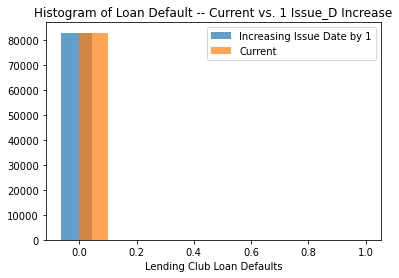

In [ ]:
# distribution comparison
plt.hist(cf_plus.point_estimate, label="Increasing Issue Date by 1", alpha=0.7)
plt.hist(y_test, label="Current", alpha=0.7)
plt.legend()
plt.xlabel("Lending Club Loan Defaults")
plt.title("Histogram of Loan Default -- Current vs. 1 Issue_D Increase")

# What if the Issue Date was much earlier?

In [ ]:
cf_minus = ca.whatif(x_test, x_test[:, 2] - 1, 2, y_test)
print("Current loan default on test dataset: ", y_test.mean())
print(
    "Average loan default with one unit decrease in issue date: ",
    cf["point_estimate"].mean(),
)

Current loan default on test dataset:  0.0013117673959612006
Average loan default with one unit decrease in issue date:  0.013319770380532892


Text(0.5, 1.0, 'Histogram of Loan Default -- Current vs. 1 Issue_D Decrease')

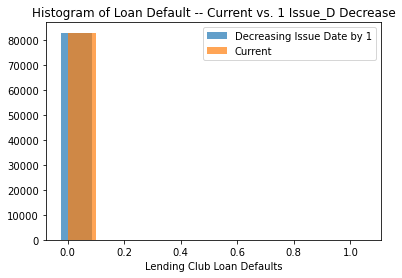

In [ ]:
# distribution comparison
plt.hist(cf_minus.point_estimate, label="Decreasing Issue Date by 1", alpha=0.7)
plt.hist(y_test, label="Current", alpha=0.7)
plt.legend()
plt.xlabel("Lending Club Loan Defaults")
plt.title("Histogram of Loan Default -- Current vs. 1 Issue_D Decrease")

# Cohort Analysis -- What is the causal effect on a new dataset?

###  Causal analysis class could also help us to learn the global and local causal effect of a new dataset given the model trained with training set. From the two tables below, you could see the global effect on test set is similar with training set, and the local effect gives you the heterogeneous treatment effect for each observation.

In [ ]:
# global effect on new dataset
ca.cohort_causal_effect(x_test)

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
issue_d,-0.012006,0.001120,-10.722349,7.994693e-27,-0.014200,-0.009811
out_prncp,0.011535,0.000969,11.900298,1.179247e-32,0.009635,0.013435
last_pymnt_d,-0.002964,0.000156,-19.054963,5.975863e-81,-0.003269,-0.002659
total_pymnt,-0.003144,0.000933,-3.368004,7.571457e-04,-0.004973,-0.001314
int_rate,0.001467,0.000226,6.477491,9.326012e-11,0.001023,0.001911
last_pymnt_amnt,0.001361,0.000851,1.598457,1.099413e-01,-0.000308,0.003030
last_credit_pull_d,-0.003017,0.000800,-3.768931,1.639485e-04,-0.004585,-0.001448
total_rec_int,-0.000897,0.000851,-1.053319,2.921947e-01,-0.002565,0.000772
dti,0.000228,0.000151,1.516349,1.294312e-01,-0.000067,0.000524


In [ ]:
# local effect on new dataset
ca.local_causal_effect(x_test)

# Part B: The DoubleML Approach - What are the causal factors for Spotify music popularity?

### DoubleMLData objects can be initialized from pandas.DataFrame’s as well as numpy.ndarray’s.


### Parameters
* data (pandas.DataFrame) – The data.

* y_col (str) – The outcome variable.

* d_cols (str or list) – The treatment variable(s).

* x_cols (None, str or list) – The covariates. If None, all variables (columns of data) which are neither specified as outcome variable y_col, nor treatment variables d_cols, nor instrumental variables z_cols are used as covariates. Default is None.

* z_cols (None, str or list) – The instrumental variable(s). Default is None.
use_other_treat_as_covariate (bool) – Indicates whether in the multiple-treatment case the other treatment variables should be added as covariates. Default is True.

* force_all_x_finite (bool or str) – Indicates whether to raise an error on infinite values and / or missings in the covariates x. Possible values are: True (neither missings np.nan, pd.NA nor infinite values np.inf are allowed), False (missings and infinite values are allowed), 'allow-nan' (only missings are allowed). Note that the choice False and 'allow-nan' are only reasonable if the machine learning methods used for the nuisance functions are capable to provide valid predictions with missings and / or infinite values in the covariates x. Default is True.

In [ ]:
%pip install xgboost

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install doubleml

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# doubleml
import doubleml as dml

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn import datasets, ensemble

import xgboost as xgb

from xgboost import XGBClassifier, XGBRFRegressor

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', 
              {'axes.spines.top': False,
               'axes.spines.bottom': False,
               'axes.spines.left': False,
               'axes.spines.right': False})

# Load Spotify data and create dataframe

In [ ]:
# create a dataframe
df = pd.read_csv('https://s3.ap-northeast-1.wasabisys.com/pubdatasets/spotify_popularity.csv')

In [ ]:
df

,id,name,artists,popularity,year,release_date,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,explicit,duration_ms
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",4,1921,1921,0.0594,0.98200,0.279,0.211,0.878000,0.6650,-20.096,0.0366,80.954,10,1,0,831667
1,7xPhfUan2yNtyFG0cUWkt8,Clancy Lowered the Boom,['Dennis Day'],5,1921,1921,0.9630,0.73200,0.819,0.341,0.000000,0.1600,-12.441,0.4150,60.936,7,1,0,180533
2,1o6I8BglA6ylDMrIELygv1,Gati Bali,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,5,1921,1921,0.0394,0.96100,0.328,0.166,0.913000,0.1010,-14.850,0.0339,110.339,3,1,0,500062
3,3ftBPsC5vPBKxYSee08FDH,Danny Boy,['Frank Parker'],3,1921,1921,0.1650,0.96700,0.275,0.309,0.000028,0.3810,-9.316,0.0354,100.109,5,1,0,210000
4,4d6HGyGT8e121BsdKmw9v6,When Irish Eyes Are Smiling,['Phil Regan'],2,1921,1921,0.2530,0.95700,0.418,0.193,0.000002,0.2290,-10.096,0.0380,101.665,3,1,0,166693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0KkIkfsLEJbrcIhYsCL7L5,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",72,2020,29/5/20,0.6080,0.08460,0.786,0.808,0.000289,0.0822,-3.702,0.0881,105.029,7,1,0,301714
170649,0OStKKAuXlxA0fMH54Qs6E,Halloweenie III: Seven Days,['Ashnikko'],68,2020,23/10/20,0.7340,0.20600,0.717,0.753,0.000000,0.1010,-6.020,0.0605,137.936,7,1,0,150654
170650,4BZXVFYCb76Q0Klojq4piV,AYA,['MAMAMOO'],76,2020,3/11/20,0.6370,0.10100,0.634,0.858,0.000009,0.2580,-2.226,0.0809,91.688,4,0,0,211280
170651,5SiZJoLXp3WOl3J4C8IK0d,Darkness,['Eminem'],70,2020,17/1/20,0.1950,0.00998,0.671,0.623,0.000008,0.6430,-7.161,0.3080,75.055,2,1,1,337147


In [ ]:
df_sample = df.sample(n=10000, replace=False, random_state=123)

In [ ]:
df_sample

,id,name,artists,popularity,year,release_date,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,explicit,duration_ms
128009,4vAYohPl9RVuDoXKODVl7x,Rise 'N' Shine,"['J.J. Johnson', 'Kai Winding']",8,1956,1/2/56,0.921,0.911000,0.497,0.626,0.747000,0.3510,-11.274,0.0664,154.336,7,0,0,140027
95207,1E10dvhY2rqIeu92aXTlHq,"Violin Concerto, Op. 77, in D: Allegro giocoso...","['Johannes Brahms', 'Jascha Heifetz', 'Serge K...",1,1952,1952,0.453,0.965000,0.415,0.360,0.689000,0.2580,-11.257,0.0546,93.779,2,1,0,457880
43536,2iyQCZ7PW08e610hw1jDHK,Cancion,['Machito Orchestra'],4,1951,1/1/51,0.600,0.968000,0.407,0.346,0.784000,0.1510,-13.027,0.0325,92.083,7,1,0,175147
135084,523HruoIx6BPW8JhZ6La3o,Apache Rose Peacock,['Red Hot Chili Peppers'],28,1991,24/9/91,0.857,0.003080,0.712,0.723,0.000006,0.0664,-10.141,0.0578,91.880,9,1,0,282133
120754,0Ei6HMtz7OXokDQ0HmUfOu,Cum on Feel the Noize,['Quiet Riot'],43,1999,1999,0.486,0.013900,0.415,0.905,0.029900,0.1430,-5.842,0.1280,145.399,11,0,0,287760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20829,0ZsoJHPxlpzN68fuP1Zd7I,Pituca,['Carlos Gardel'],2,1930,18/8/30,0.793,0.965000,0.699,0.378,0.001410,0.1680,-10.383,0.0716,123.478,3,1,0,164427
166324,6WBj6LfYrkF1n4jpVyH0Sa,If You Want Me To,['Ginny Owens'],33,1999,20/7/99,0.166,0.928000,0.387,0.281,0.000204,0.1430,-13.411,0.0352,124.056,9,1,0,214933
6263,6Foycbbnrh1pYGHPAZMkia,I'm A Fool To Care,"['Les Paul', 'Mary Ford']",19,1953,1/1/53,0.213,0.968000,0.588,0.103,0.000019,0.1930,-15.584,0.0396,67.994,7,1,0,176467
11885,7zSAI7Ae6DPVepN8MksKVZ,Space Age Love Song,['A Flock Of Seagulls'],53,1981,1981,0.552,0.000036,0.447,0.744,0.106000,0.2100,-4.613,0.0311,139.959,2,1,0,226693


In [ ]:
# convert milliseconds to minutes

df_sample['duration_ms'] = df_sample['duration_ms'].div(60000)
df_sample

,id,name,artists,popularity,year,release_date,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,explicit,duration_ms
128009,4vAYohPl9RVuDoXKODVl7x,Rise 'N' Shine,"['J.J. Johnson', 'Kai Winding']",8,1956,1/2/56,0.921,0.911000,0.497,0.626,0.747000,0.3510,-11.274,0.0664,154.336,7,0,0,2.333783
95207,1E10dvhY2rqIeu92aXTlHq,"Violin Concerto, Op. 77, in D: Allegro giocoso...","['Johannes Brahms', 'Jascha Heifetz', 'Serge K...",1,1952,1952,0.453,0.965000,0.415,0.360,0.689000,0.2580,-11.257,0.0546,93.779,2,1,0,7.631333
43536,2iyQCZ7PW08e610hw1jDHK,Cancion,['Machito Orchestra'],4,1951,1/1/51,0.600,0.968000,0.407,0.346,0.784000,0.1510,-13.027,0.0325,92.083,7,1,0,2.919117
135084,523HruoIx6BPW8JhZ6La3o,Apache Rose Peacock,['Red Hot Chili Peppers'],28,1991,24/9/91,0.857,0.003080,0.712,0.723,0.000006,0.0664,-10.141,0.0578,91.880,9,1,0,4.702217
120754,0Ei6HMtz7OXokDQ0HmUfOu,Cum on Feel the Noize,['Quiet Riot'],43,1999,1999,0.486,0.013900,0.415,0.905,0.029900,0.1430,-5.842,0.1280,145.399,11,0,0,4.796000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20829,0ZsoJHPxlpzN68fuP1Zd7I,Pituca,['Carlos Gardel'],2,1930,18/8/30,0.793,0.965000,0.699,0.378,0.001410,0.1680,-10.383,0.0716,123.478,3,1,0,2.740450
166324,6WBj6LfYrkF1n4jpVyH0Sa,If You Want Me To,['Ginny Owens'],33,1999,20/7/99,0.166,0.928000,0.387,0.281,0.000204,0.1430,-13.411,0.0352,124.056,9,1,0,3.582217
6263,6Foycbbnrh1pYGHPAZMkia,I'm A Fool To Care,"['Les Paul', 'Mary Ford']",19,1953,1/1/53,0.213,0.968000,0.588,0.103,0.000019,0.1930,-15.584,0.0396,67.994,7,1,0,2.941117
11885,7zSAI7Ae6DPVepN8MksKVZ,Space Age Love Song,['A Flock Of Seagulls'],53,1981,1981,0.552,0.000036,0.447,0.744,0.106000,0.2100,-4.613,0.0311,139.959,2,1,0,3.778217


In [ ]:
df_sample.popularity.describe()

count    10000.000000
mean        31.416400
std         21.708356
min          0.000000
25%         12.000000
50%         33.000000
75%         48.000000
max         96.000000
Name: popularity, dtype: float64

In [ ]:
df_sample['explicit'].value_counts()

0    9142
1     858
Name: explicit, dtype: int64

In [ ]:
df_sample['mode'].value_counts()

1    6997
0    3003
Name: mode, dtype: int64

In [ ]:
df_sample.columns

Index(['id', 'name', 'artists', 'popularity', 'year', 'release_date',
       'valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'key', 'mode',
       'explicit', 'duration_ms'],
      dtype='object')

###  Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. Integer data type.

### The visualisations below make use of Seaborn distribution of data plots: https://seaborn.pydata.org/tutorial/distributions.html

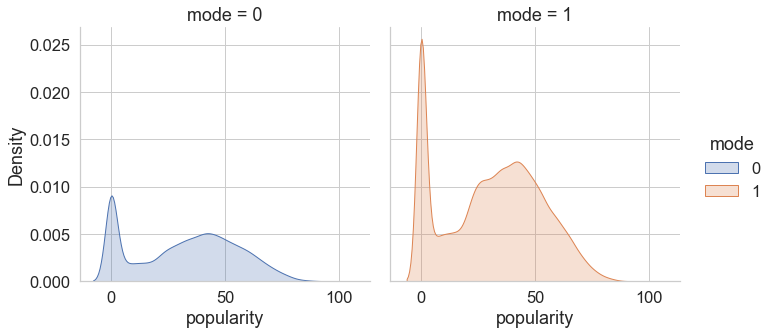

In [ ]:
_ = sns.displot(df, 
                x="popularity", 
                hue="mode", 
                col="mode",
                kind="kde", 
                fill=True
                )

### Explicit - this is where songs are use explicit lyrics and may not be appropriate listening for the general community.

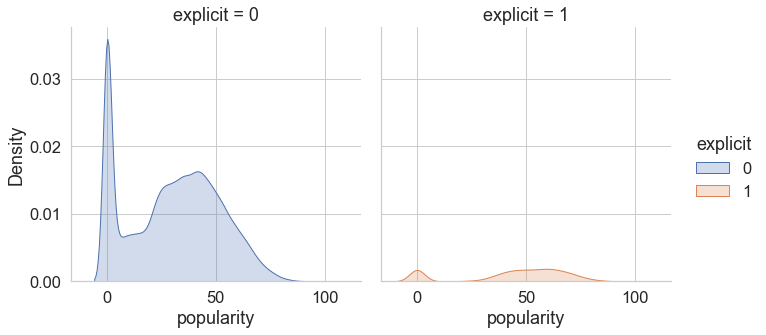

In [ ]:
_ = sns.displot(df, 
                x="popularity", 
                hue="explicit", 
                col="explicit",
                kind="kde", 
                fill=True
                )

### As a first estimate, we calculate the *unconditional* average predictive effect (APE) 

In [ ]:
df[['mode', 'popularity']].groupby('mode').mean().diff()

,popularity
mode,
0,NaN
1,-1.385648


### The table above (mode APE) shows that the *unconditional*  APE is approximately -1.385648.

In [ ]:
df[['explicit', 'popularity']].groupby('explicit').mean().diff()

,popularity
explicit,
0,NaN
1,15.025128


### The unconditional APE makes up the  *baseline* estimates.

### The table above (explicit APE) shows that the *unconditional*  APE is approximately 15.025128.

### These estimates are biased since they do not account for heterogeneity and endogeneity (broadly refers to situations in which an explanatory variable is correlated with the error term) of songs.

### Questions:
*  Mode: does it effect song popularity?
*  Explicit (language): effects on song popularity?

### The variables to examine:
* outcome: popularity  (of song)
* treatment variables: mode, explicit

## DoubleML: Create Base Data Features

In [ ]:
columns = list(df.columns)
columns

['id',
 'name',
 'artists',
 'popularity',
 'year',
 'release_date',
 'valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'key',
 'mode',
 'explicit',
 'duration_ms']

In [ ]:
feature_base = [
 'valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'key',
 'duration_ms']

feature_base

['valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'key',
 'duration_ms']

# DoubleML Data Backend: DoubleMLData

### To start our analysis, we create a new instance of a DoubleMLData object. 
### We implement the regression model by using scikit-learn’s PolynomialFeatures class.

### To implement both models (basic and flexible), we generate two data backends: 
* data_dml_base, and 
* data_dml_flex.

### Create DML Base Data

In [ ]:
df['duration_ms'] = df['duration_ms'].div(60000)
df

,id,name,artists,popularity,year,release_date,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,key,mode,explicit,duration_ms
0,4BJqT0PrAfrxzMOxytFOIz,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",4,1921,1921,0.0594,0.98200,0.279,0.211,0.878000,0.6650,-20.096,0.0366,80.954,10,1,0,13.861117
1,7xPhfUan2yNtyFG0cUWkt8,Clancy Lowered the Boom,['Dennis Day'],5,1921,1921,0.9630,0.73200,0.819,0.341,0.000000,0.1600,-12.441,0.4150,60.936,7,1,0,3.008883
2,1o6I8BglA6ylDMrIELygv1,Gati Bali,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,5,1921,1921,0.0394,0.96100,0.328,0.166,0.913000,0.1010,-14.850,0.0339,110.339,3,1,0,8.334367
3,3ftBPsC5vPBKxYSee08FDH,Danny Boy,['Frank Parker'],3,1921,1921,0.1650,0.96700,0.275,0.309,0.000028,0.3810,-9.316,0.0354,100.109,5,1,0,3.500000
4,4d6HGyGT8e121BsdKmw9v6,When Irish Eyes Are Smiling,['Phil Regan'],2,1921,1921,0.2530,0.95700,0.418,0.193,0.000002,0.2290,-10.096,0.0380,101.665,3,1,0,2.778217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0KkIkfsLEJbrcIhYsCL7L5,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",72,2020,29/5/20,0.6080,0.08460,0.786,0.808,0.000289,0.0822,-3.702,0.0881,105.029,7,1,0,5.028567
170649,0OStKKAuXlxA0fMH54Qs6E,Halloweenie III: Seven Days,['Ashnikko'],68,2020,23/10/20,0.7340,0.20600,0.717,0.753,0.000000,0.1010,-6.020,0.0605,137.936,7,1,0,2.510900
170650,4BZXVFYCb76Q0Klojq4piV,AYA,['MAMAMOO'],76,2020,3/11/20,0.6370,0.10100,0.634,0.858,0.000009,0.2580,-2.226,0.0809,91.688,4,0,0,3.521333
170651,5SiZJoLXp3WOl3J4C8IK0d,Darkness,['Eminem'],70,2020,17/1/20,0.1950,0.00998,0.671,0.623,0.000008,0.6430,-7.161,0.3080,75.055,2,1,1,5.619117


### First: make music "mode" the treatment variable

In [ ]:
# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(
    df,
    y_col='popularity',
    d_cols='mode',
    x_cols=feature_base)

In [ ]:
data_dml_base.__dict__

In [ ]:
print(data_dml_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: popularity
Treatment variable(s): ['mode']
Covariates: ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms']
Instrument variable(s): None
No. Observations: 170653

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Columns: 19 entries, id to duration_ms
dtypes: float64(10), int64(5), object(4)
memory usage: 24.7+ MB



### From the base DML data model, the covariates are:

In [ ]:
# The Covariates are:
Covariates: ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms']

### Select features from the base DML data:

### Create Flexible Data Model (contains polynomial features)

*  second degree polynomial: ax^2+bx+c

In [ ]:
# Set up a model according to regression formula with polynomials
features = df.copy()[['liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms']]
features

,liveness,loudness,speechiness,tempo,key,duration_ms
0,0.6650,-20.096,0.0366,80.954,10,13.861117
1,0.1600,-12.441,0.4150,60.936,7,3.008883
2,0.1010,-14.850,0.0339,110.339,3,8.334367
3,0.3810,-9.316,0.0354,100.109,5,3.500000
4,0.2290,-10.096,0.0380,101.665,3,2.778217
...,...,...,...,...,...,...
170648,0.0822,-3.702,0.0881,105.029,7,5.028567
170649,0.1010,-6.020,0.0605,137.936,7,2.510900
170650,0.2580,-2.226,0.0809,91.688,4,3.521333
170651,0.6430,-7.161,0.3080,75.055,2,5.619117


In [ ]:
['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness']

### From the remaining features, select some features that will become polynomials.

In [ ]:
# these features will be second degree polynomials
poly_dict = {'valence': 2, 
              'acousticness': 2,
              'danceability': 2,
              'energy': 2,
              'instrumentalness': 2
              }

In [ ]:
for key, degree in poly_dict.items():
    
    poly = PolynomialFeatures(degree, include_bias=False)
    
    data_transf = poly.fit_transform(df[[key]])

    x_cols = poly.get_feature_names([key])
    
    data_transf = pd.DataFrame(data_transf, columns=x_cols)

    features = pd.concat((features, data_transf),axis=1, sort=False)

In [ ]:
features

,liveness,loudness,speechiness,tempo,key,duration_ms,valence,valence^2,acousticness,acousticness^2,danceability,danceability^2,energy,energy^2,instrumentalness,instrumentalness^2
0,0.6650,-20.096,0.0366,80.954,10,13.861117,0.0594,0.003528,0.98200,0.964324,0.279,0.077841,0.211,0.044521,0.878000,7.708840e-01
1,0.1600,-12.441,0.4150,60.936,7,3.008883,0.9630,0.927369,0.73200,0.535824,0.819,0.670761,0.341,0.116281,0.000000,0.000000e+00
2,0.1010,-14.850,0.0339,110.339,3,8.334367,0.0394,0.001552,0.96100,0.923521,0.328,0.107584,0.166,0.027556,0.913000,8.335690e-01
3,0.3810,-9.316,0.0354,100.109,5,3.500000,0.1650,0.027225,0.96700,0.935089,0.275,0.075625,0.309,0.095481,0.000028,7.672900e-10
4,0.2290,-10.096,0.0380,101.665,3,2.778217,0.2530,0.064009,0.95700,0.915849,0.418,0.174724,0.193,0.037249,0.000002,2.822400e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.0822,-3.702,0.0881,105.029,7,5.028567,0.6080,0.369664,0.08460,0.007157,0.786,0.617796,0.808,0.652864,0.000289,8.352100e-08
170649,0.1010,-6.020,0.0605,137.936,7,2.510900,0.7340,0.538756,0.20600,0.042436,0.717,0.514089,0.753,0.567009,0.000000,0.000000e+00
170650,0.2580,-2.226,0.0809,91.688,4,3.521333,0.6370,0.405769,0.10100,0.010201,0.634,0.401956,0.858,0.736164,0.000009,7.327360e-11
170651,0.6430,-7.161,0.3080,75.055,2,5.619117,0.1950,0.038025,0.00998,0.000100,0.671,0.450241,0.623,0.388129,0.000008,5.700250e-11


In [ ]:
model_data = pd.concat((df.copy()[['popularity', 'mode']], features.copy()),axis=1, sort=False)
model_data

,popularity,mode,liveness,loudness,speechiness,tempo,key,duration_ms,valence,valence^2,acousticness,acousticness^2,danceability,danceability^2,energy,energy^2,instrumentalness,instrumentalness^2
0,4,1,0.6650,-20.096,0.0366,80.954,10,13.861117,0.0594,0.003528,0.98200,0.964324,0.279,0.077841,0.211,0.044521,0.878000,7.708840e-01
1,5,1,0.1600,-12.441,0.4150,60.936,7,3.008883,0.9630,0.927369,0.73200,0.535824,0.819,0.670761,0.341,0.116281,0.000000,0.000000e+00
2,5,1,0.1010,-14.850,0.0339,110.339,3,8.334367,0.0394,0.001552,0.96100,0.923521,0.328,0.107584,0.166,0.027556,0.913000,8.335690e-01
3,3,1,0.3810,-9.316,0.0354,100.109,5,3.500000,0.1650,0.027225,0.96700,0.935089,0.275,0.075625,0.309,0.095481,0.000028,7.672900e-10
4,2,1,0.2290,-10.096,0.0380,101.665,3,2.778217,0.2530,0.064009,0.95700,0.915849,0.418,0.174724,0.193,0.037249,0.000002,2.822400e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,72,1,0.0822,-3.702,0.0881,105.029,7,5.028567,0.6080,0.369664,0.08460,0.007157,0.786,0.617796,0.808,0.652864,0.000289,8.352100e-08
170649,68,1,0.1010,-6.020,0.0605,137.936,7,2.510900,0.7340,0.538756,0.20600,0.042436,0.717,0.514089,0.753,0.567009,0.000000,0.000000e+00
170650,76,0,0.2580,-2.226,0.0809,91.688,4,3.521333,0.6370,0.405769,0.10100,0.010201,0.634,0.401956,0.858,0.736164,0.000009,7.327360e-11
170651,70,1,0.6430,-7.161,0.3080,75.055,2,5.619117,0.1950,0.038025,0.00998,0.000100,0.671,0.450241,0.623,0.388129,0.000008,5.700250e-11


In [ ]:
# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_flex = dml.DoubleMLData(model_data, y_col='popularity', d_cols='mode')

In [ ]:
print(data_dml_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: popularity
Treatment variable(s): ['mode']
Covariates: ['liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms', 'valence', 'valence^2', 'acousticness', 'acousticness^2', 'danceability', 'danceability^2', 'energy', 'energy^2', 'instrumentalness', 'instrumentalness^2']
Instrument variable(s): None
No. Observations: 170653

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Columns: 18 entries, popularity to instrumentalness^2
dtypes: float64(15), int64(3)
memory usage: 23.4 MB



# Estimate Causal Effect

## (1) Partially Linear Regression Model (PLR)

### We start using lasso to estimate the function g0  and m0 in the following PLR model:

### To estimate the causal parameter theta0 here, we use double machine learning with 3-fold cross-fitting.

### Estimation of the nuisance components and , is based on the lasso with cross-validated choice of the penalty term, as provided by scikit-learn. 

### We load the learner by initializing instances from the classes LassoCV and LogisticRegressionCV. Hyperparameters and options can be set during instantiation of the learner.
### Here we specify that the lasso should use that value of that minimizes the cross-validated mean squared error which is based on 10-fold cross validation.

### We start by estimation the ATE in the basic model and then repeat the estimation in the flexible model.



In [ ]:
np.random.seed(123)

In [ ]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, max_iter=10000))

### LassoCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html and https://scikit-learn.org/stable/modules/linear_model.html#lasso

### LogisticRegressionCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

In [ ]:
lasso_class = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(
        cv=10, 
        penalty='l1', 
        solver='liblinear',
        Cs = Cs, 
        max_iter=1000))

### Nuisance Parameters

### In statistical hypothesis testing, a population parameter of secondary interest that must be accounted for in order to obtain an estimated value for a parameter of primary interest.

### class doubleml.DoubleMLPLR(obj_dml_data, ml_g, ml_m, n_folds=5, n_rep=1, score='partialling out', dml_procedure='dml2', draw_sample_splitting=True, apply_cross_fitting=True)

* Parameters obj_dml_data (DoubleMLData object) – The DoubleMLData object providing the data and specifying the variables for the causal model.

* ml_g (estimator implementing fit() and predict()) – A machine learner implementing fit() and predict() methods (e.g. sklearn.ensemble.RandomForestRegressor) for the nuisance function .

* ml_m (estimator implementing fit() and predict()) – A machine learner implementing fit() and predict() methods (e.g. sklearn.ensemble.RandomForestRegressor) for the nuisance function . For binary treatment variables (with values 0 and 1), a classifier implementing fit() and predict_proba() can also be specified. If sklearn.base.is_classifier() returns True, predict_proba() is used otherwise predict().

* n_folds (int) – Number of folds. Default is 5.

* n_rep (int) – Number of repetitons for the sample splitting. Default is 1.

* score (str or callable) – A str ('partialling out' or 'IV-type') specifying the score function or a callable object / function with signature psi_a, psi_b = score(y, d, g_hat, m_hat, smpls). Default is 'partialling out'.

* dml_procedure (str) – A str ('dml1' or 'dml2') specifying the double machine learning algorithm. Default is 'dml2'.

* draw_sample_splitting (bool) – Indicates whether the sample splitting should be drawn during initialization of the object. Default is True.

* apply_cross_fitting (bool) – Indicates whether cross-fitting should be applied. Default is True.

### PLR on Base Data

In [ ]:
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(
    data_dml_base,
    ml_g = lasso,
    ml_m = lasso_class,
    n_folds = 3)

In [ ]:
dml_plr_lasso.fit(store_predictions=True)

In [ ]:
dml_plr_lasso.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.420447,0.088811,-4.734205,0.000002,-0.594513,-0.246382


### PLR on Flex Data

In [ ]:
# Estimate the ATE in the flexible model with lasso
np.random.seed(123)
dml_plr_lasso = dml.DoubleMLPLR(
    data_dml_flex,
    ml_g = lasso,
    ml_m = lasso_class,
    n_folds = 3)

In [ ]:
dml_plr_lasso.fit(store_predictions=True)

In [ ]:
lasso_summary = dml_plr_lasso.summary
lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.639381,0.085917,-7.441822,9.930610e-14,-0.807775,-0.470986


### Other algorithms to solve PLR

#### Random Forest

In [ ]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, 
    max_depth=7, 
    max_features=3, 
    min_samples_leaf=3)


randomForest_class = RandomForestClassifier(
    n_estimators=500, 
    max_depth=5, 
    max_features=4, 
    min_samples_leaf=7)

np.random.seed(123)

# create model
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)

# train model
dml_plr_forest.fit(store_predictions=True)

# summary
forest_summary = dml_plr_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.543126,0.082177,-6.609243,3.862896e-11,-0.704189,-0.382063


####  Trees

In [ ]:
# Trees
trees = DecisionTreeRegressor(
    max_depth=30, 
    ccp_alpha=0.0047, 
    min_samples_split=203, 
    min_samples_leaf=67)


trees_class = DecisionTreeClassifier(
    max_depth=30, 
    ccp_alpha=0.0042, 
    min_samples_split=104, 
    min_samples_leaf=34)

np.random.seed(123)

# create  model
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 3)

# train  model
dml_plr_tree.fit(store_predictions=True)

# summarise
tree_summary = dml_plr_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.376476,0.08021,-4.693651,0.000003,-0.533684,-0.219268


#### Boosted Trees

#### https://xgboost.readthedocs.io/en/latest/

####  XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [ ]:
# Boosted Trees
boost = xgb.XGBRegressor(n_jobs=1, 
                     objective = "reg:squarederror",
                     eta=0.1, 
                     n_estimators=35)


boost_class = xgb.XGBClassifier(use_label_encoder=False, 
                            n_jobs=1,
                            objective = "binary:logistic", 
                            eval_metric = "logloss",
                            eta=0.1, 
                            n_estimators=34)

np.random.seed(123)

# create  model
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3)

# train
dml_plr_boost.fit(store_predictions=True)

# summarise
boost_summary = dml_plr_boost.summary

boost_summary	

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.236293,0.080913,-2.920342,0.003496,-0.394878,-0.077707


### Summarise all PLR results

In [ ]:
plr_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
plr_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
plr_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,-0.639381,-0.807775,-0.470986
forest,-0.543126,-0.704189,-0.382063
tree,-0.376476,-0.533684,-0.219268
xgboost,-0.236293,-0.394878,-0.077707


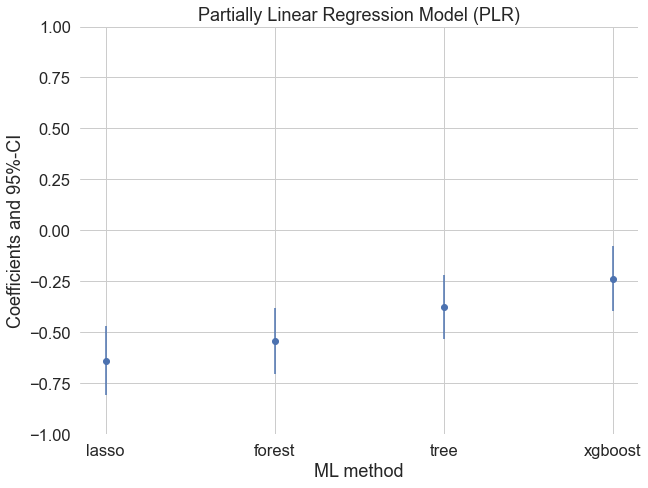

In [ ]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-1, 1])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

# (2): Interactive Regression Model (IRM)
### We consider estimation of average treatment effects when treatment effects are fully heterogeneous:

In [ ]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)


dml_irm_lasso = dml.DoubleMLIRM(data_dml_flex,
                          ml_g = lasso,
                          ml_m = lasso_class,
                          trimming_threshold = 0.01,
                          n_folds = 3)


dml_irm_lasso.fit(store_predictions=True)


lasso_summary = dml_irm_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.530386,0.087275,-6.077164,1.223270e-09,-0.701442,-0.35933


In [ ]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)

randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)

dml_irm_forest = dml.DoubleMLIRM(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_forest.set_ml_nuisance_params('ml_g0', 'mode', {
    'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 7})
dml_irm_forest.set_ml_nuisance_params('ml_g1', 'mode', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 5})
dml_irm_forest.set_ml_nuisance_params('ml_m', 'mode', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 6})

dml_irm_forest.fit(store_predictions=True)

forest_summary = dml_irm_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.516268,0.079881,-6.462969,1.026681e-10,-0.672832,-0.359705


In [ ]:
# Trees
trees = DecisionTreeRegressor(max_depth=30)

trees_class = DecisionTreeClassifier(max_depth=30)

np.random.seed(123)

dml_irm_tree = dml.DoubleMLIRM(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               trimming_threshold = 0.01,
                               n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_tree.set_ml_nuisance_params('ml_g0', 'mode', {
    'ccp_alpha': 0.0016, 'min_samples_split': 74, 'min_samples_leaf': 24})
dml_irm_tree.set_ml_nuisance_params('ml_g1', 'mode', {
    'ccp_alpha': 0.0018, 'min_samples_split': 70, 'min_samples_leaf': 23})
dml_irm_tree.set_ml_nuisance_params('ml_m', 'mode', {
    'ccp_alpha': 0.0028, 'min_samples_split': 167, 'min_samples_leaf': 55})

dml_irm_tree.fit(store_predictions=True)

tree_summary = dml_irm_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,-0.295576,0.083171,-3.553823,0.00038,-0.458588,-0.132563


In [ ]:
# Boosted Trees
boost = xgb.XGBRegressor(n_jobs=1, objective = "reg:squarederror")

boost_class = xgb.XGBClassifier(use_label_encoder=False, n_jobs=1, objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)

dml_irm_boost = dml.DoubleMLIRM(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                trimming_threshold = 0.01,
                                n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_boost.set_ml_nuisance_params('ml_g0', 'mode', {
    'eta': 0.1, 'n_estimators': 8})
dml_irm_boost.set_ml_nuisance_params('ml_g1', 'mode', {
    'eta': 0.1, 'n_estimators': 29})
dml_irm_boost.set_ml_nuisance_params('ml_m', 'mode', {
    'eta': 0.1, 'n_estimators': 23})

dml_irm_boost.fit(store_predictions=True)

boost_summary = dml_irm_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
mode,0.967348,0.096106,10.065412,7.855740e-24,0.778984,1.155713


In [ ]:
irm_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
irm_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
irm_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,-0.530386,-0.701442,-0.359330
forest,-0.516268,-0.672832,-0.359705
tree,-0.295576,-0.458588,-0.132563
xgboost,0.967348,0.778984,1.155713


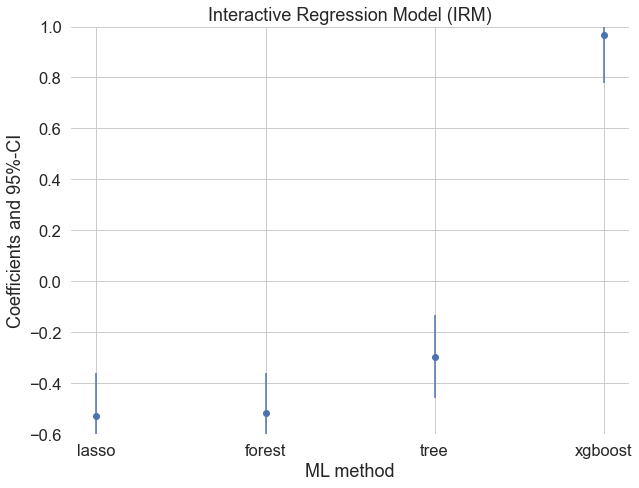

In [ ]:
errors = np.full((2, irm_summary.shape[0]), np.nan)
errors[0, :] = irm_summary['coef'] - irm_summary['2.5 %']
errors[1, :] = irm_summary['97.5 %'] - irm_summary['coef']
plt.errorbar(irm_summary.index, irm_summary.coef, fmt='o', yerr=errors)
plt.ylim([-0.6, 1.0])

plt.title('Interactive Regression Model (IRM)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

### Interpretations: These estimates that flexibly account for confounding are substantially attenuated relative to the baseline estimate (-1.385648) that does not account for confounding. The results suggest much larger causal effects of musical mode on the popularity of songs.

# Local Average Treatment Effects of Certain Features on Song Popularity

###  (3) Interactive IV Model (IIVM)

### In the examples above, we estimated the average treatment effect of mode on the popularity of  songs. 

### Now, we consider estimation of local average treatment effects (LATE) of explicit songs using the song's mode as an instrument for the explicit nature of songs.

In [ ]:
feature_base

['valence',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'key',
 'duration_ms']

### Base Data

In [ ]:
# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = dml.DoubleMLData(df,
                                    y_col='popularity',
                                    d_cols='explicit',
                                    z_cols='mode',
                                    x_cols=feature_base)

print(data_dml_base_iv)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: popularity
Treatment variable(s): ['explicit']
Covariates: ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms']
Instrument variable(s): ['mode']
No. Observations: 170653

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Columns: 19 entries, id to duration_ms
dtypes: float64(10), int64(5), object(4)
memory usage: 24.7+ MB



### Flex Data

In [ ]:
# Flexible model
model_data = pd.concat((df.copy()[['popularity', 'mode', 'explicit']], features.copy()), axis=1, sort=False)

data_dml_iv_flex = dml.DoubleMLData(model_data,
                                    y_col='popularity',
                                    d_cols='explicit',
                                    z_cols='mode')

print(data_dml_iv_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: popularity
Treatment variable(s): ['explicit']
Covariates: ['liveness', 'loudness', 'speechiness', 'tempo', 'key', 'duration_ms', 'valence', 'valence^2', 'acousticness', 'acousticness^2', 'danceability', 'danceability^2', 'energy', 'energy^2', 'instrumentalness', 'instrumentalness^2']
Instrument variable(s): ['mode']
No. Observations: 170653

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Columns: 19 entries, popularity to instrumentalness^2
dtypes: float64(15), int64(4)
memory usage: 24.7 MB



In [ ]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)


dml_iivm_lasso = dml.DoubleMLIIVM(data_dml_iv_flex,
                                  ml_g = lasso,
                                  ml_m = lasso_class,
                                  ml_r = lasso_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)


dml_iivm_lasso.fit(store_predictions=True)


lasso_summary = dml_iivm_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
explicit,31.21533,5.376152,5.806258,6.388434e-09,20.678265,41.752395


In [ ]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)

randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)

dml_iivm_forest = dml.DoubleMLIIVM(data_dml_base_iv,
                                   ml_g = randomForest,
                                   ml_m = randomForest_class,
                                   ml_r = randomForest_class,
                                   subgroups = {'always_takers': False,
                                                'never_takers': True},
                                   trimming_threshold = 0.01,
                                   n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_forest.set_ml_nuisance_params('ml_g0', 'explicit', {
    'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 7})
dml_iivm_forest.set_ml_nuisance_params('ml_g1', 'explicit', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 5})
dml_iivm_forest.set_ml_nuisance_params('ml_m', 'explicit', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 6})
dml_iivm_forest.set_ml_nuisance_params('ml_r1', 'explicit', {
    'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 6})

dml_iivm_forest.fit(store_predictions=True)

forest_summary = dml_iivm_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
explicit,35.403089,5.974406,5.925793,3.107948e-09,23.693469,47.112708


In [ ]:
# Trees
trees = DecisionTreeRegressor(max_depth=30)

trees_class = DecisionTreeClassifier(max_depth=30)

np.random.seed(123)

dml_iivm_tree = dml.DoubleMLIIVM(data_dml_base_iv,
                                 ml_g = trees,
                                 ml_m = trees_class,
                                 ml_r = trees_class,
                                 subgroups = {'always_takers': False,
                                              'never_takers': True},
                                 trimming_threshold = 0.01,
                                 n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_tree.set_ml_nuisance_params('ml_g0', 'explicit', {
    'ccp_alpha': 0.0016, 'min_samples_split': 74, 'min_samples_leaf': 24})
dml_iivm_tree.set_ml_nuisance_params('ml_g1', 'explicit', {
    'ccp_alpha': 0.0018, 'min_samples_split': 70, 'min_samples_leaf': 23})
dml_iivm_tree.set_ml_nuisance_params('ml_m', 'explicit', {
    'ccp_alpha': 0.0028, 'min_samples_split': 167, 'min_samples_leaf': 55})
dml_iivm_tree.set_ml_nuisance_params('ml_r1', 'explicit', {
    'ccp_alpha': 0.0576, 'min_samples_split': 55, 'min_samples_leaf': 18})

dml_iivm_tree.fit(store_predictions=True)

tree_summary = dml_iivm_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
explicit,7.173026,2.014751,3.560254,0.00037,3.224186,11.121866


In [ ]:
# Boosted Trees
boost = xgb.XGBRegressor(n_jobs=1, objective = "reg:squarederror")

boost_class = xgb.XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_iivm_boost = dml.DoubleMLIIVM(data_dml_base_iv,
                                  ml_g = boost,
                                  ml_m = boost_class,
                                  ml_r = boost_class,
                                  subgroups = {'always_takers': False,
                                               'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_boost.set_ml_nuisance_params('ml_g0', 'explicit', {
    'eta': 0.1, 'n_estimators': 9})
dml_iivm_boost.set_ml_nuisance_params('ml_g1', 'explicit', {
    'eta': 0.1, 'n_estimators': 33})
dml_iivm_boost.set_ml_nuisance_params('ml_m', 'explicit', {
    'eta': 0.1, 'n_estimators': 12})
dml_iivm_boost.set_ml_nuisance_params('ml_r1', 'explicit', {
    'eta': 0.1, 'n_estimators': 25})

dml_iivm_boost.fit(store_predictions=True)

boost_summary = dml_iivm_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
explicit,-480.58364,139.604779,-3.442458,0.000576,-754.203978,-206.963302


In [ ]:
iivm_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
iivm_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
iivm_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,31.215330,20.678265,41.752395
forest,35.403089,23.693469,47.112708
tree,7.173026,3.224186,11.121866
xgboost,-480.583640,-754.203978,-206.963302


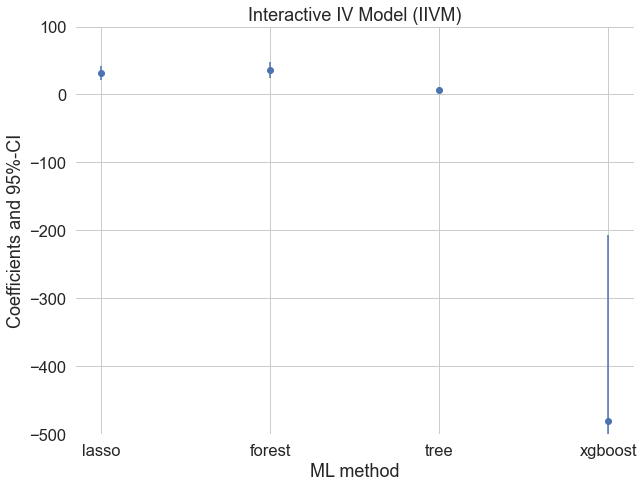

In [ ]:
errors = np.full((2, iivm_summary.shape[0]), np.nan)
errors[0, :] = iivm_summary['coef'] - iivm_summary['2.5 %']
errors[1, :] = iivm_summary['97.5 %'] - iivm_summary['coef']
plt.errorbar(iivm_summary.index, iivm_summary.coef, fmt='o', yerr=errors)
plt.ylim([-500, 100])

plt.title('Interactive IV Model (IIVM)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

# Final Summary of Results

In [ ]:
df_summary = pd.concat((plr_summary, irm_summary, iivm_summary)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('PLR', 4), np.repeat('IRM', 4), np.repeat('IIVM', 4)))
df_summary.set_index(['Model', 'ML'])

coef     std err          t         P>|t|       2.5 %  \
Model ML                                                                     
PLR   lasso     -0.639381    0.085917  -7.441822  9.930610e-14   -0.807775   
      forest    -0.543126    0.082177  -6.609243  3.862896e-11   -0.704189   
      tree      -0.376476    0.080210  -4.693651  2.683720e-06   -0.533684   
      xgboost   -0.236293    0.080913  -2.920342  3.496474e-03   -0.394878   
IRM   lasso     -0.530386    0.087275  -6.077164  1.223270e-09   -0.701442   
      forest    -0.516268    0.079881  -6.462969  1.026681e-10   -0.672832   
      tree      -0.295576    0.083171  -3.553823  3.796754e-04   -0.458588   
      xgboost    0.967348    0.096106  10.065412  7.855740e-24    0.778984   
IIVM  lasso     31.215330    5.376152   5.806258  6.388434e-09   20.678265   
      forest    35.403089    5.974406   5.925793  3.107948e-09   23.693469   
      tree       7.173026    2.014751   3.560254  3.704965e-04    3.224186   
      xgboost -480.583640  139.604779  -3.442458  5.764526e-04 -754.203978   

                   97.5 %  
Model ML                   
PLR   lasso     -0.470986  
      forest    -0.382063  
      tree      -0.219268  
      xgboost   -0.077707  
IRM   lasso     -0.359330  
      forest    -0.359705  
      tree      -0.132563  
      xgboost    1.155713  
IIVM  lasso     41.752395  
      forest    47.112708  
      tree      11.121866  
      xgboost -206.963302

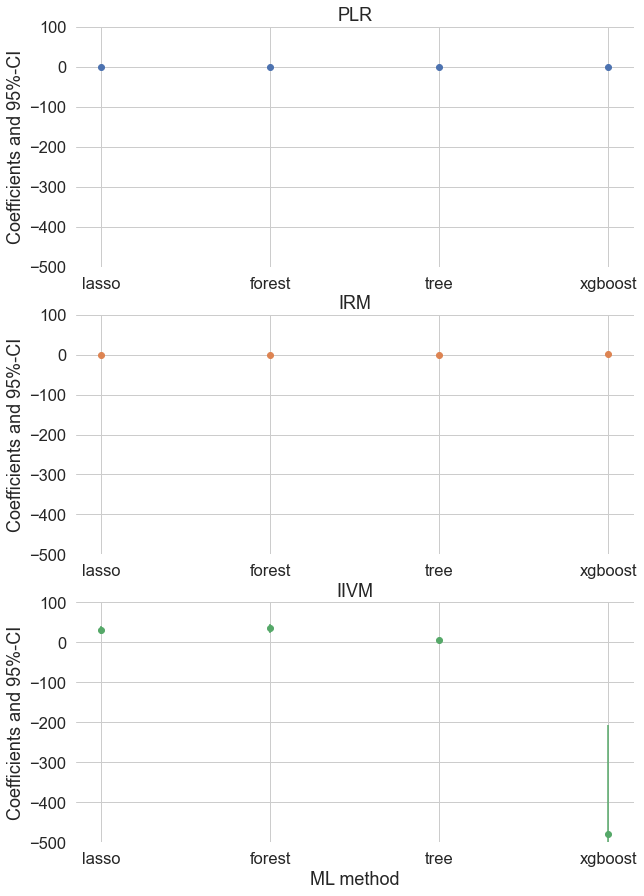

In [ ]:
plt.figure(figsize=(10, 15))
colors = sns.color_palette()
for ind, model in enumerate(['PLR', 'IRM', 'IIVM']):
    plt.subplot(3, 1, ind+1)
    this_df = df_summary.query('Model == @model')
    errors = np.full((2, this_df.shape[0]), np.nan)
    errors[0, :] = this_df['coef'] - this_df['2.5 %']
    errors[1, :] = this_df['97.5 %'] - this_df['coef']
    plt.errorbar(this_df.ML, this_df.coef, fmt='o', yerr=errors,
                 color=colors[ind], ecolor=colors[ind])
    plt.ylim([-500, 100])
    plt.title(model)
    plt.ylabel('Coefficients and 95%-CI')

_ = plt.xlabel('ML method')

#  Conclusions: since the APE baseline for the explicitness of songs is 15.025128, and DML shows that the estimates of the teatment effects are highly significant, we would reject the (NULL HYPOTHESIS) that the explicitness songs do not effect the song's popularity.